In [136]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv


In [62]:
train = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/train.csv")
print(train.shape)
print(train["date"].nunique())
print(train["store"].nunique())
print(train["item"].nunique())
nItem = 50
nStore = 10
# 1826 = 365 + 365 + 365 + 366 + 365 = 1826
train.head()

(913000, 4)
1826
10
50


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
test = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/test.csv")
print(test.shape)
print(test["date"].nunique())
print(test["store"].nunique())
print(test["item"].nunique())
# 31+28+31 = 90 dates 
# 90 * 10 * 50 = 45000\
test.head(100)

(45000, 4)
90
10
50


,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
95,95,2018-01-06,2,1
96,96,2018-01-07,2,1
97,97,2018-01-08,2,1
98,98,2018-01-09,2,1


Comments 
1. Data very structured.

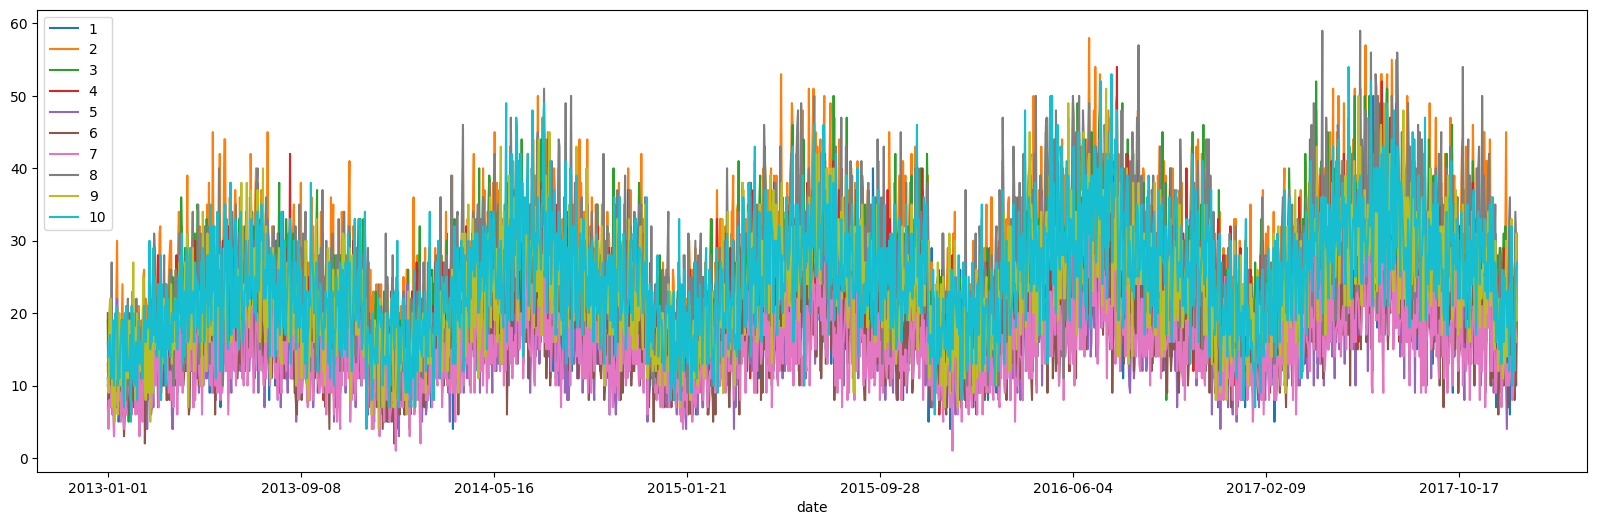

In [7]:
# # Check if correlation between item and store .. Is different stores there is correlation with same item?

# Item 0
plot = train[train["item"] == 1][["date","store","sales"]]
fig, ax = plt.subplots(figsize=(20,6))
for label, df in plot.groupby('store'):
    df.plot(x = "date", y ="sales", ax=ax, label=label)
plt.legend()
plt.show()

In [114]:
# groupbyItem = train.groupBy("item")
# train.drop(["date"], axis = "columns").corr()
# df = train.drop(["date"], axis = "columns").set_index(['store'])
# df
corr_items_within_sameStore = [{} for i in range(nStore)]
corr_store_within_sameItem = [{} for i in range(nItem)]
for k,v in train.groupby(["item","store"]):
    corr_items_within_sameStore[k[1] - 1][k[0]] = list(v["sales"])
    corr_store_within_sameItem[k[0] - 1][k[1]] = list(v["sales"])
# print(corr_items_within_sameStore[0])
corr_items_within_sameStore_metrics = []
for i in range(nStore):
    df = pd.DataFrame(corr_items_within_sameStore[i])
    corr_items_within_sameStore_metrics.append(df.corr(method = "pearson"))
    
corr_store_within_sameItem_metrics = []
for i in range(nItem):
    df = pd.DataFrame(corr_store_within_sameItem[i])
    corr_store_within_sameItem_metrics.append(df.corr(method = "pearson"))
    

#df.columns = ['{}_{}'.format(t, v) for v,t in df.columns]

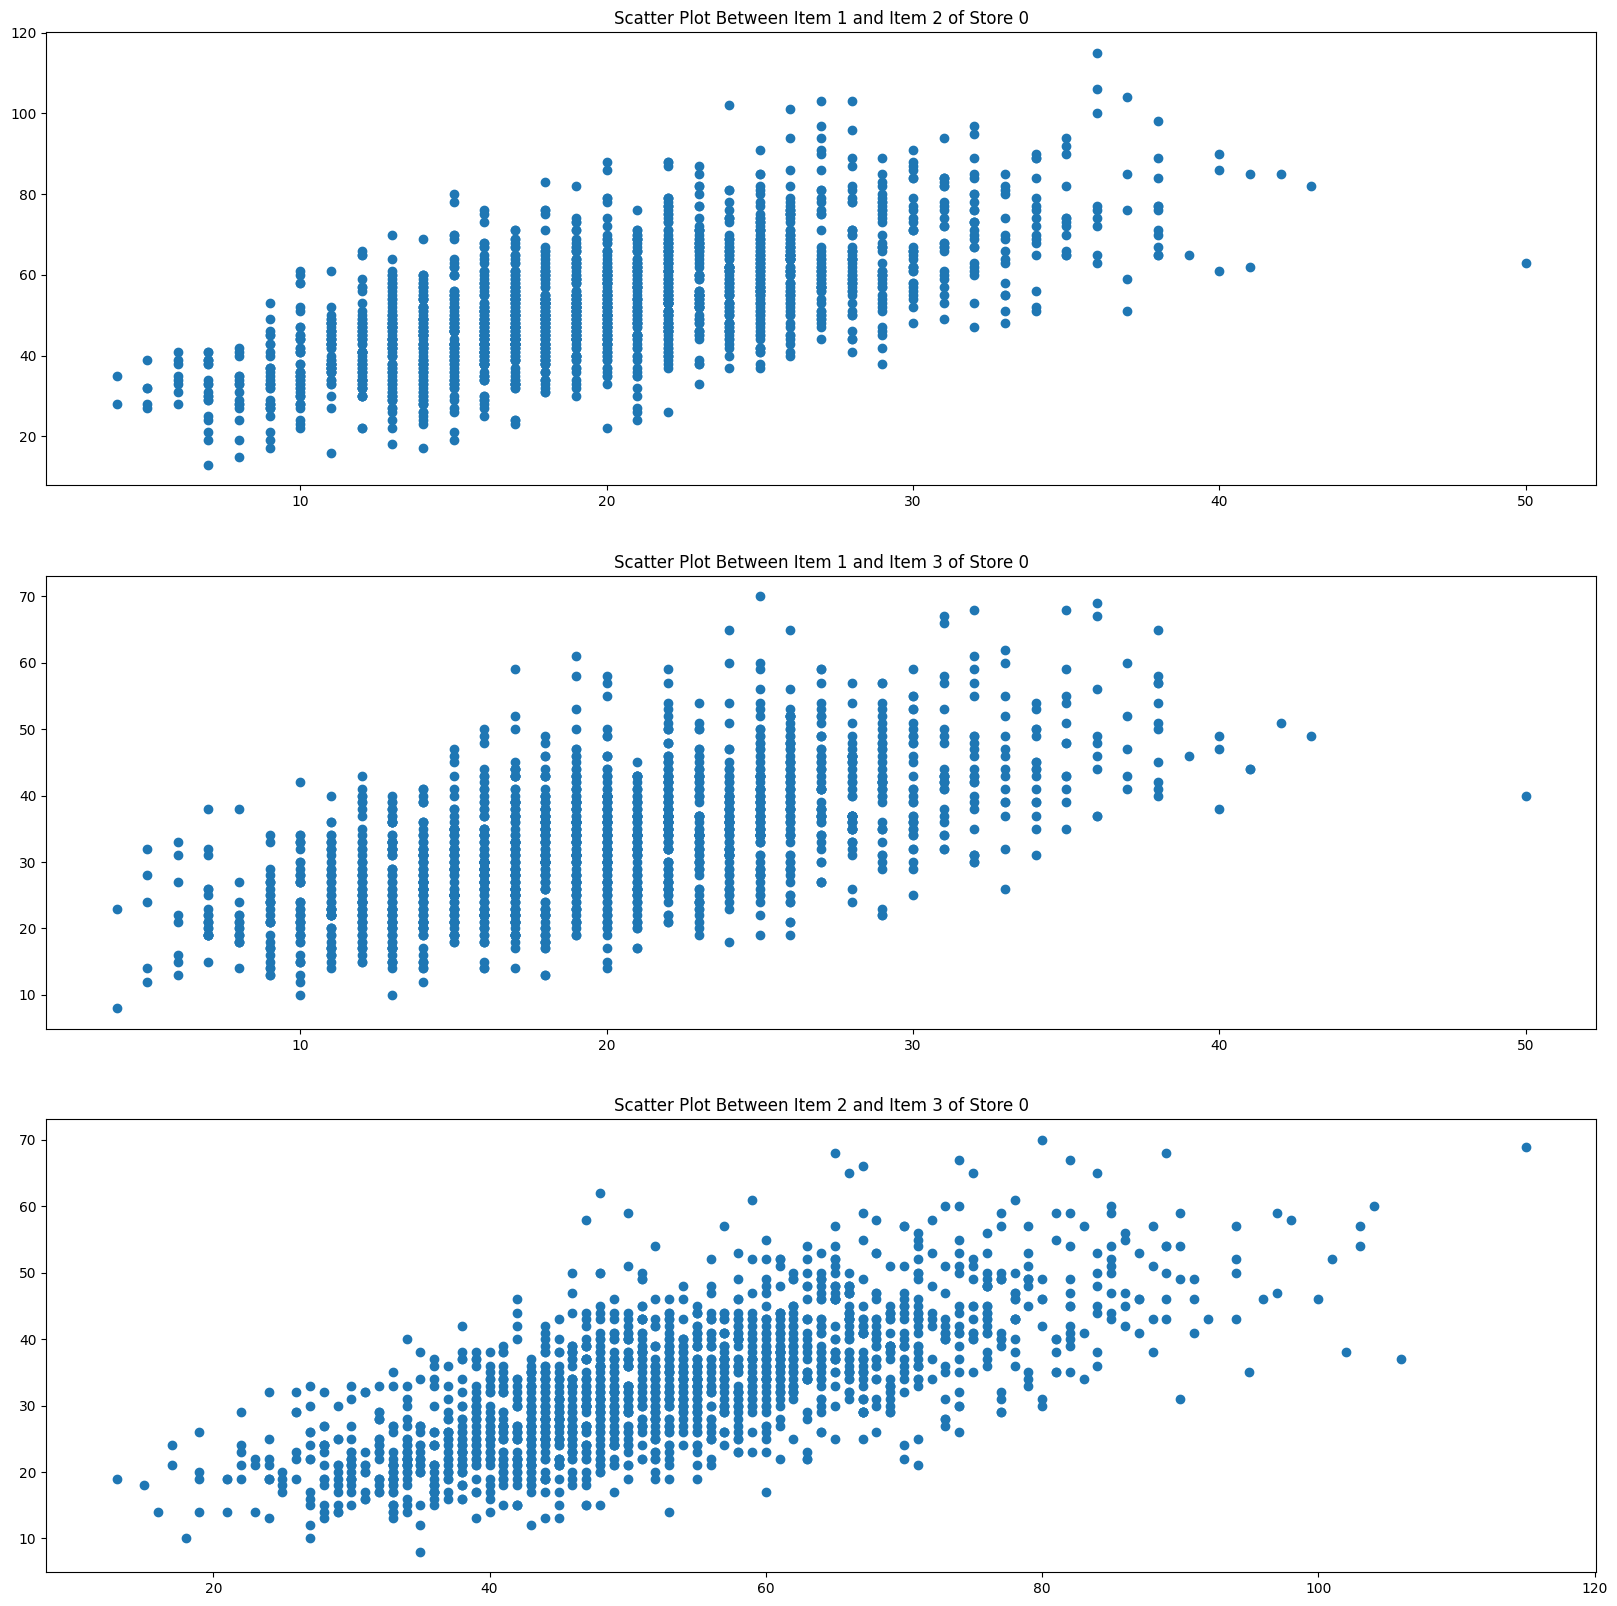

<Figure size 640x480 with 0 Axes>

In [128]:
test = pd.DataFrame(corr_items_within_sameStore[0])[[1,2,3]]
fig, ax = plt.subplots(nrows = 3, figsize=(20,20))
ax[0].scatter(test[1],test[2])
ax[0].set_title("Scatter Plot Between Item 1 and Item 2 of Store 0")

ax[1].scatter(test[1],test[3])
ax[1].set_title("Scatter Plot Between Item 1 and Item 3 of Store 0")

ax[2].scatter(test[2],test[3])
ax[2].set_title("Scatter Plot Between Item 2 and Item 3 of Store 0")

plt.show()
plt.savefig("Scatter Plot between Item of same store")

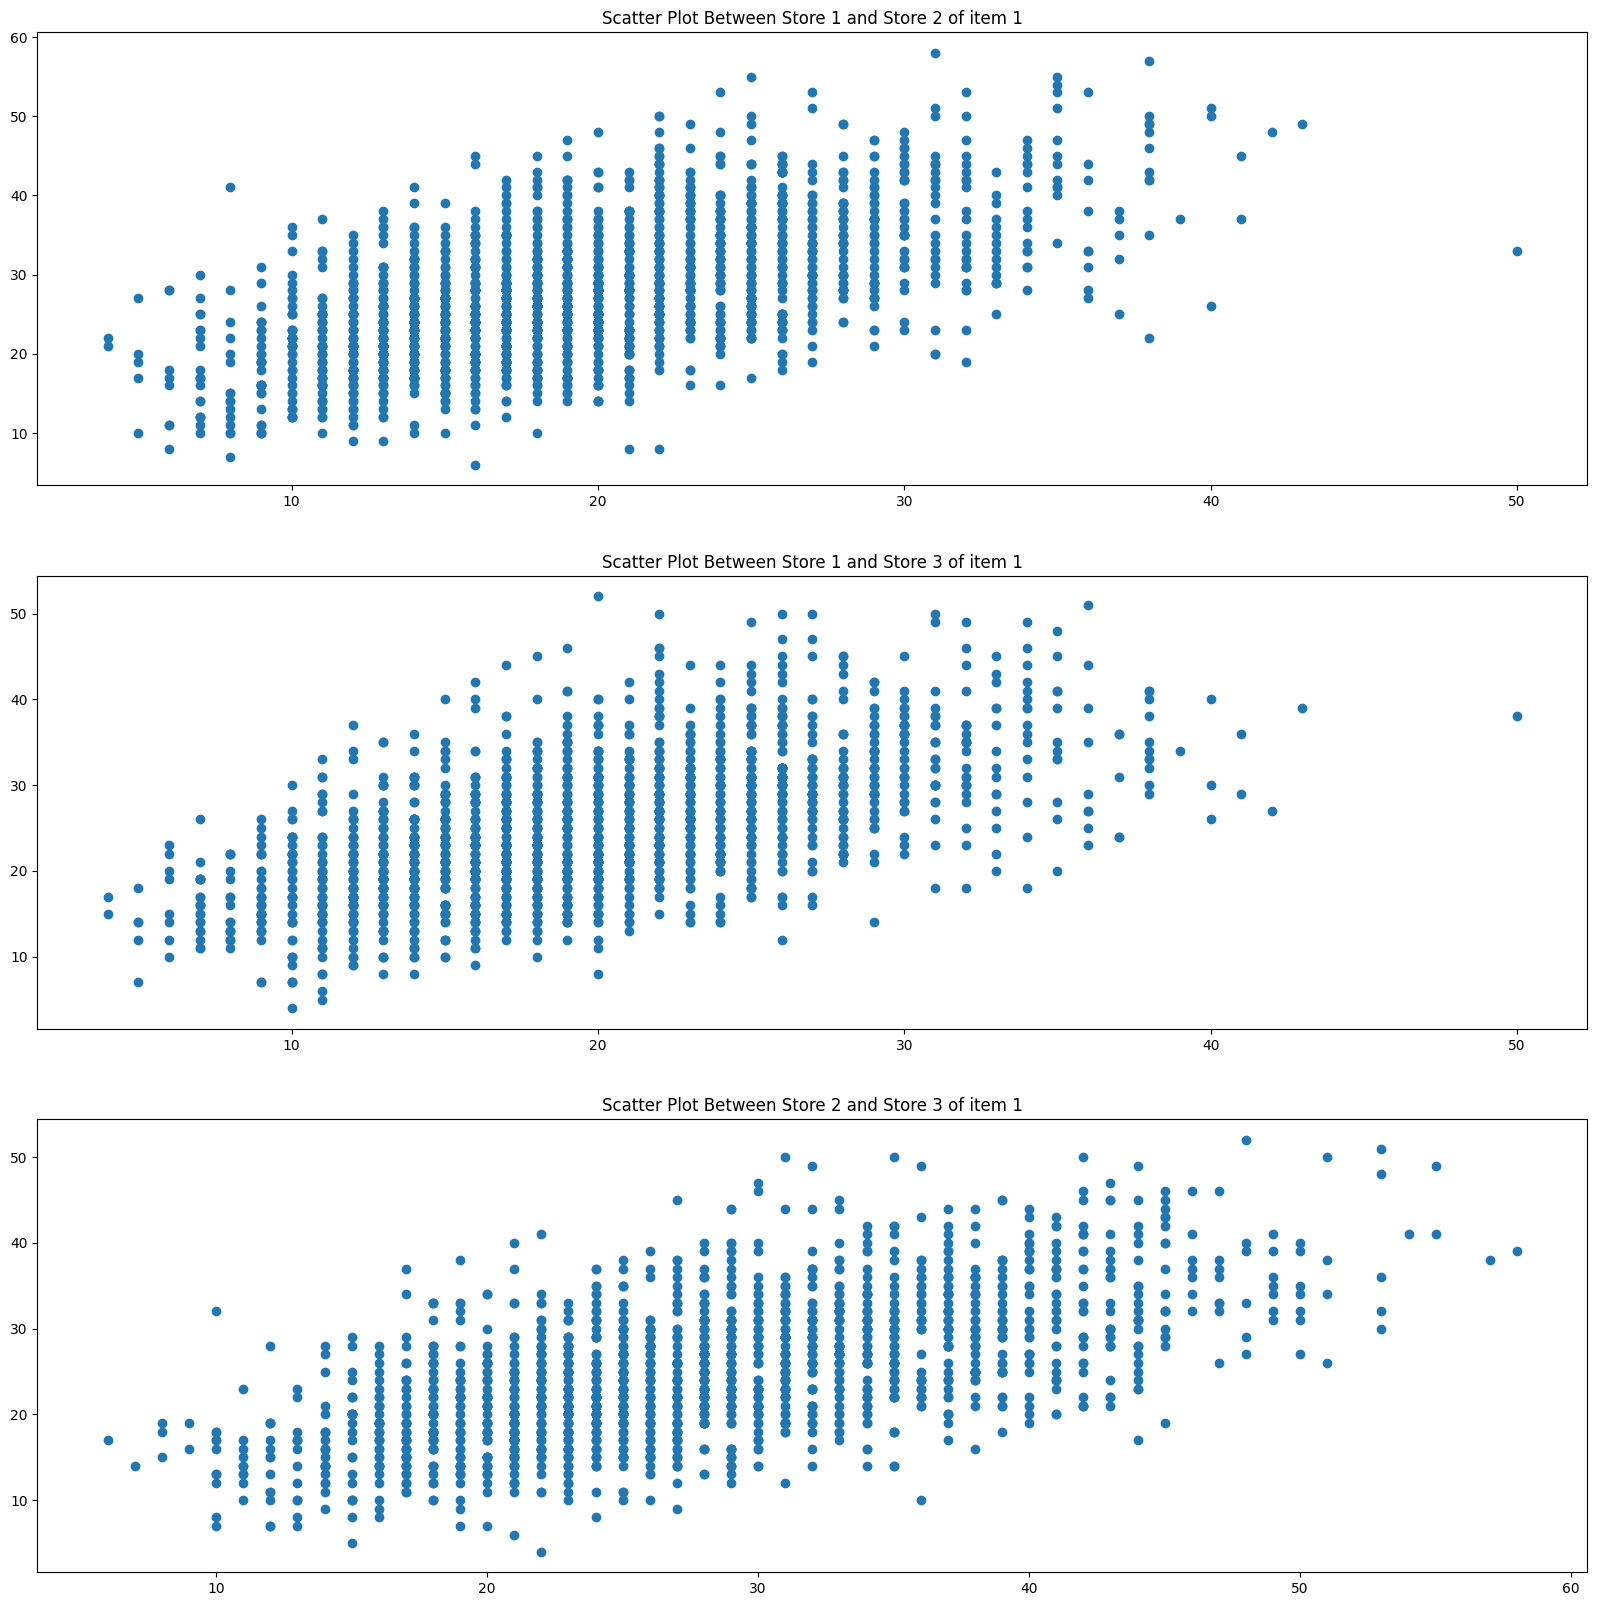

<Figure size 640x480 with 0 Axes>

In [130]:
test = pd.DataFrame(corr_store_within_sameItem[0])[[1,2,3]]
fig, ax = plt.subplots(nrows = 3, figsize=(20,20))
ax[0].scatter(test[1],test[2])
ax[0].set_title("Scatter Plot Between Store 1 and Store 2 of item 1")

ax[1].scatter(test[1],test[3])
ax[1].set_title("Scatter Plot Between Store 1 and Store 3 of item 1")

ax[2].scatter(test[2],test[3])
ax[2].set_title("Scatter Plot Between Store 2 and Store 3 of item 1")

plt.show()
plt.savefig("Scatter Plot between store of same It4em")

In [115]:
storeId = 1
for met in corr_items_within_sameStore_metrics:
    print("Store Id =", storeId)
    print(met)
    storeId += 1    
# itemId = 1
# os.mkdir("correlation_between_stores_for_item")
# for met in corr_store_within_sameItem_metrics:
#     path = "correlation_between_stores_for_item/" + str(itemId) + ".csv"
#     met.to_csv(path,index = True, header= True)
#     itemId += 1

Store Id = 1
          1         2         3         4         5         6         7   \
1   1.000000  0.668528  0.618264  0.548314  0.548090  0.640845  0.674364   
2   0.668528  1.000000  0.709252  0.640327  0.626936  0.759303  0.755162   
3   0.618264  0.709252  1.000000  0.605427  0.583285  0.713721  0.712618   
4   0.548314  0.640327  0.605427  1.000000  0.519196  0.642641  0.642635   
5   0.548090  0.626936  0.583285  0.519196  1.000000  0.620243  0.616850   
6   0.640845  0.759303  0.713721  0.642641  0.620243  1.000000  0.751811   
7   0.674364  0.755162  0.712618  0.642635  0.616850  0.751811  1.000000   
8   0.674897  0.778543  0.729711  0.661891  0.630612  0.770888  0.790964   
9   0.662899  0.743104  0.693733  0.653682  0.588255  0.756067  0.758501   
10  0.672424  0.769525  0.733464  0.648521  0.617646  0.775131  0.784820   
11  0.669855  0.780279  0.727894  0.654784  0.644509  0.768898  0.775712   
12  0.684176  0.777060  0.721400  0.655125  0.634571  0.774344  0.780664   

In [90]:
storeId = 1
if !os.exists("correlation_between_items_in_store"):
    os.mkdir("correlation_between_items_in_store")
for met in corr_items_within_sameStore_metrics:
    path = "correlation_between_items_in_store/" + str(storeId) + ".csv"
    met.to_csv(path, index = True, header= True)
    storeId += 1
    
itemId = 1
if !os.exists("correlation_between_stores_for_item"):
    os.mkdir("correlation_between_stores_for_item")
for met in corr_store_within_sameItem_metrics:
    path = "correlation_between_stores_for_item/" + str(itemId) + ".csv"
    met.to_csv(path,index = True, header= True)
    itemId += 1

In [92]:
!zip -r "correlation_between_items_in_store.zip" "correlation_between_items_in_store"
!zip -r "correlation_between_stores_for_item.zip" "correlation_between_stores_for_item"

updating: correlation_between_items_in_store/ (stored 0%)
updating: correlation_between_items_in_store/4.csv (deflated 67%)
updating: correlation_between_items_in_store/6.csv (deflated 67%)
updating: correlation_between_items_in_store/8.csv (deflated 67%)
updating: correlation_between_items_in_store/3.csv (deflated 67%)
updating: correlation_between_items_in_store/7.csv (deflated 67%)
updating: correlation_between_items_in_store/5.csv (deflated 67%)
updating: correlation_between_items_in_store/10.csv (deflated 67%)
updating: correlation_between_items_in_store/2.csv (deflated 67%)
updating: correlation_between_items_in_store/1.csv (deflated 67%)
updating: correlation_between_items_in_store/9.csv (deflated 67%)
  adding: correlation_between_stores_for_item/ (stored 0%)
  adding: correlation_between_stores_for_item/32.csv (deflated 69%)
  adding: correlation_between_stores_for_item/46.csv (deflated 69%)
  adding: correlation_between_stores_for_item/34.csv (deflated 69%)
  adding: correlat

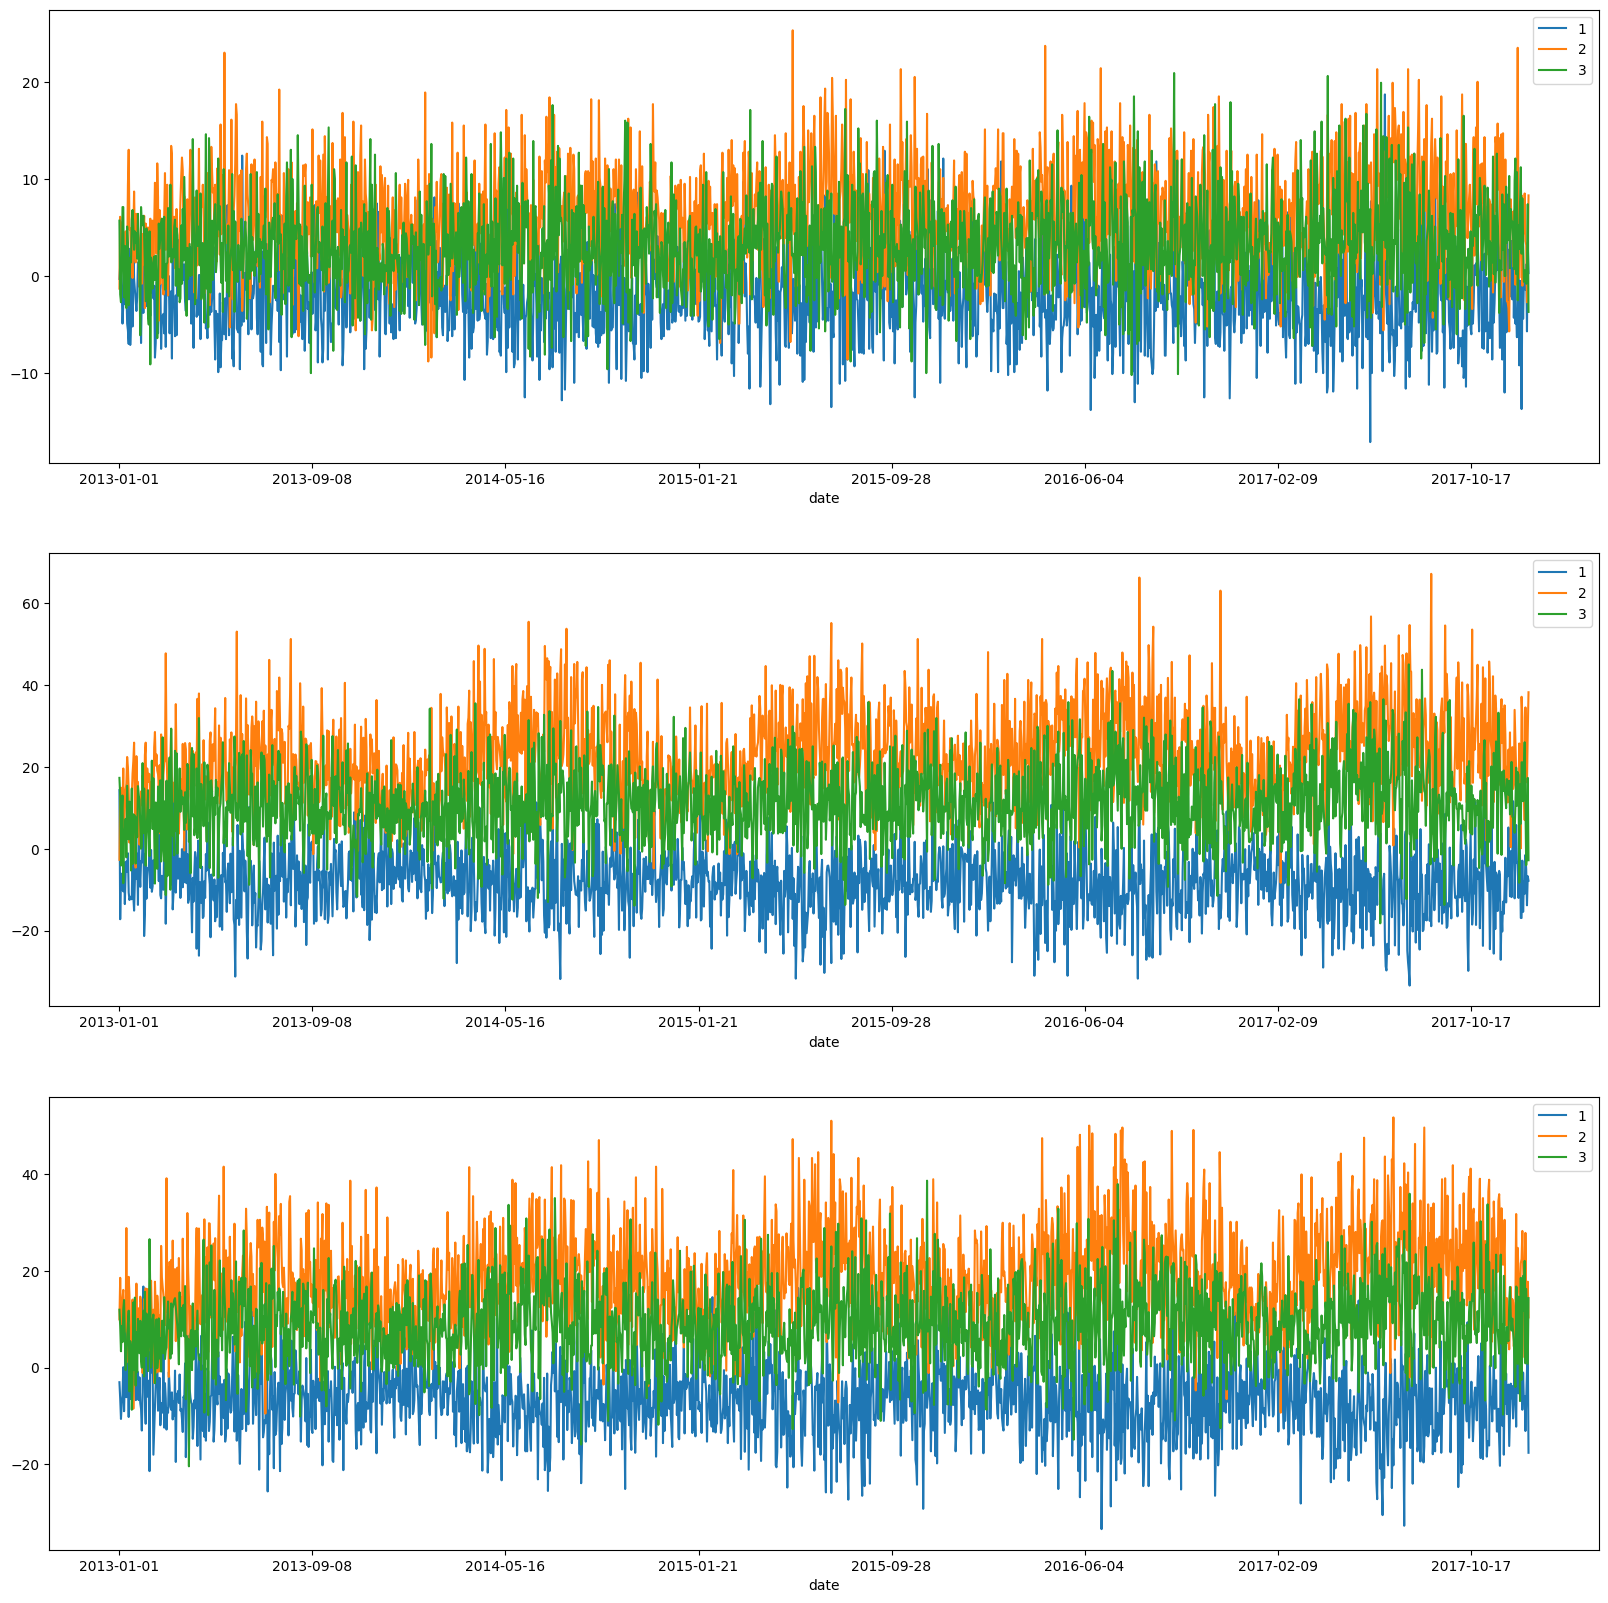

<Figure size 640x480 with 0 Axes>

In [144]:
output = [1, 25, 50]
fig, ax = plt.subplots(nrows = len(output),figsize =(20,20))

def plotting(itemId, ax):
    plot = train[train["item"] == itemId][["date","store","sales"]]
    averageSales = plot.groupby("date").mean()["sales"]
    merge = plot.merge(averageSales, left_on = "date", right_on = "date")
    merge["different"] = merge["sales_x"] - merge["sales_y"]
    merge = merge.drop(["sales_x", "sales_y"], axis = "columns")
    idx = 0
    for label, df in merge.groupby('store'):
        df.plot(x = "date", y = "different", ax=ax, label=label)
        idx += 1
        if idx == 3:
            break
for idx in range(len(output)):
    plotting(output[idx], ax[idx])
    
plt.legend()
plt.show()
plt.savefig("Plot between Different Store among different item.png")

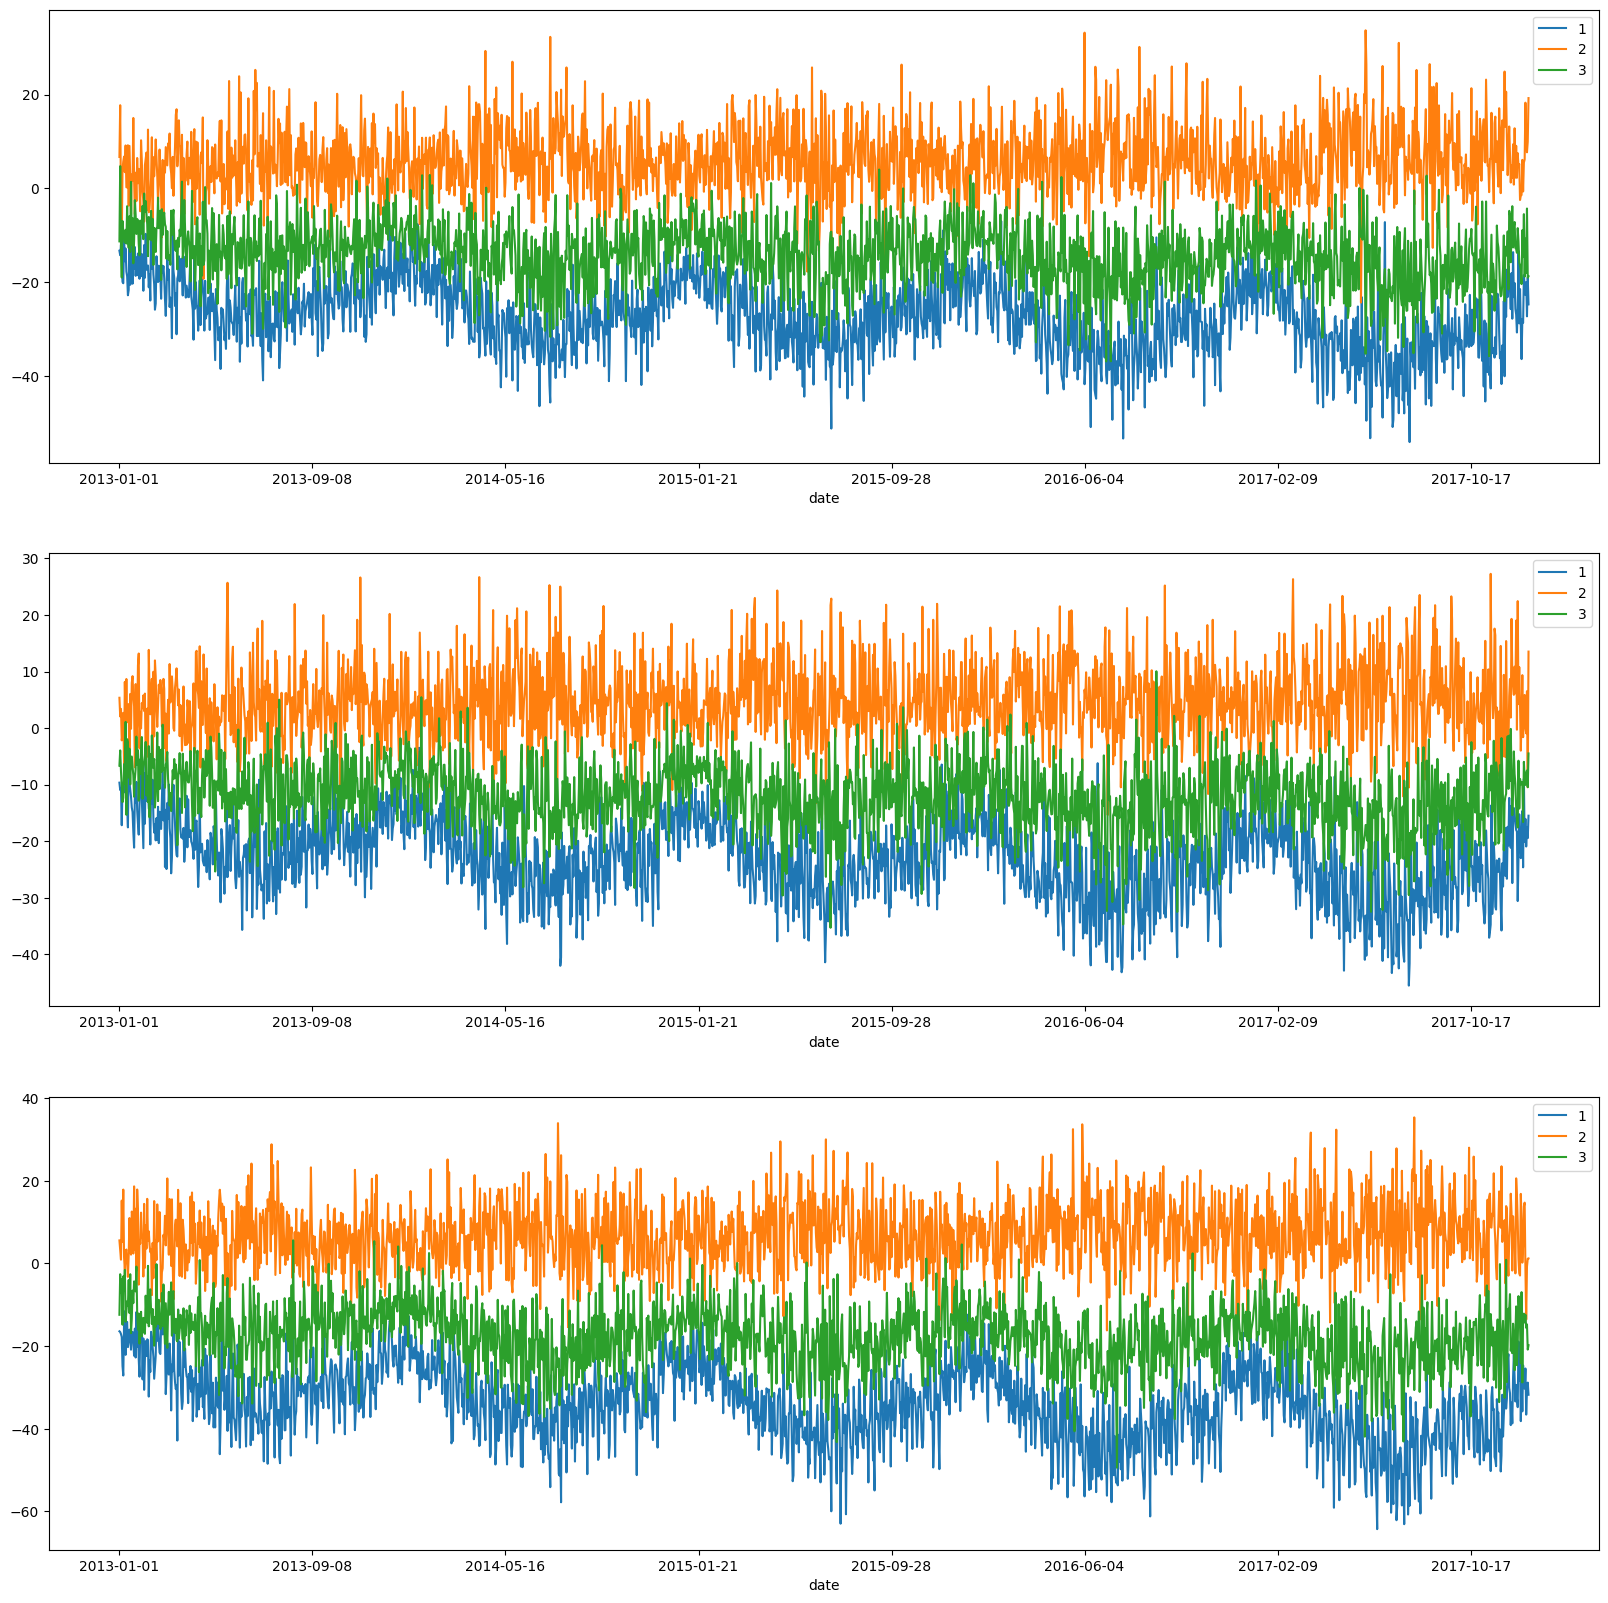

<Figure size 640x480 with 0 Axes>

In [143]:
output = [1, 5, 10]
fig, ax = plt.subplots(nrows = len(output),figsize =(20,20))

def plotting(storeId, ax):
    plot = train[train["store"] == storeId][["date","item","sales"]]

    averageSales = plot.groupby("date").mean()["sales"]
    merge = plot.merge(averageSales, left_on = "date", right_on = "date")
    merge["different"] = merge["sales_x"] - merge["sales_y"]
    merge = merge.drop(["sales_x", "sales_y"], axis = "columns")
    idx = 0
    for label, df in merge.groupby('item'):
        df.plot(x = "date", y ="different", ax=ax, label=label)
        idx += 1
        if idx == 3:
            break
for idx in range(len(output)):
    plotting(output[idx], ax[idx])

# print(merge.groupby('item').sum())
plt.legend()
plt.show()
plt.savefig("Plot between Different item among different store.png")